In [ ]:
import pandas as pd
import dask.dataframe as dd

# Algunas aclaraciones sobre el Notebook

- Utilizacion de la libreria Dask para algunas operaciones sobre dataframes (https://www.dask.org/)
- Busqueda de hiperparametros con un subset muy reducido del dataframe original, para que no explote la RAM (no me dejaba correrlo con mas que eso)
- A lo largo de los distintos pasos, se va guardando y levantando de disco, para no perder los avanzes en caso que el kernel se reinicie por falta de RAM y para liberar recursos

# Preprocessing

In [2]:
train_df = dd.read_parquet('train.parq')
test_df = dd.read_parquet('test.parq')

In [3]:
train_df['attack_month'] = train_df['attack_time'].map(lambda x: x.month).astype('int8')
train_df['attack_day'] = train_df['attack_time'].map(lambda x: x.day).astype('int8')
train_df['attack_hour'] = train_df['attack_time'].map(lambda x: x.hour).astype('int8')

test_df['attack_month'] = test_df['attack_time'].map(lambda x: x.month).astype('int8')
test_df['attack_day'] = test_df['attack_time'].map(lambda x: x.day).astype('int8')
test_df['attack_hour'] = test_df['attack_time'].map(lambda x: x.hour).astype('int8')

In [4]:
train_df = train_df.drop(['watcher_as_num', 'attack_time', 'attacker_ip_enum'], axis=1)
test_df = test_df.drop(['watcher_as_num', 'attack_time'], axis=1)

# Features with type_attack

In [5]:
train_df[['service', 'attack_type']] = train_df['attack_type'].str.split(':', expand=True, n=1).astype('category')
train_df = train_df.rename(columns={'attack_type': 'type'})

test_df[['service', 'attack_type']] = test_df['attack_type'].str.split(':', expand=True, n=1).astype('category')
test_df = test_df.rename(columns={'attack_type': 'type'})

In [6]:
train_df.compute().head()

,watcher_country,watcher_as_name,attacker_country,attacker_as_num,attacker_as_name,type,watcher_uuid_enum,label,attack_month,attack_day,attack_hour,service
0,DE,Host Europe GmbH,TR,47721.0,Murat Aktas,exploit,0,0,7,31,7,http
1,DE,Host Europe GmbH,TR,47721.0,Murat Aktas,spam,0,0,7,31,7,http
2,DE,bn:t Blatzheim Networks Telecom GmbH,DE,51167.0,Contabo GmbH,bruteforce,2,0,7,31,7,http
3,DE,bn:t Blatzheim Networks Telecom GmbH,DE,51167.0,Contabo GmbH,spam,2,0,7,31,7,http
4,DE,bn:t Blatzheim Networks Telecom GmbH,DE,51167.0,Contabo GmbH,exploit,2,0,7,31,7,http


In [7]:
test_df.compute().head()

,watcher_country,watcher_as_name,attacker_country,attacker_as_num,attacker_as_name,type,watcher_uuid_enum,attacker_ip_enum,attack_month,attack_day,attack_hour,service
0,US,IMH-IAD,IN,14061.0,DIGITALOCEAN-ASN,spam,1,7696,7,31,7,http
1,US,IMH-IAD,IN,14061.0,DIGITALOCEAN-ASN,exploit,1,7696,7,31,7,http
2,US,IMH-IAD,IN,14061.0,DIGITALOCEAN-ASN,bruteforce,1,7696,7,31,7,http
3,US,IMH-IAD,IN,14061.0,DIGITALOCEAN-ASN,bruteforce,1,7696,7,31,7,http
4,US,GOOGLE-CLOUD-PLATFORM,US,53667.0,PONYNET,bruteforce,3,7543,7,31,7,http


# Val and train split

In [8]:
from sklearn.model_selection import train_test_split
train_df = train_df.compute()
X_train, X_val = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

# Imputation of Nulls

In [9]:
from dask_ml.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
train_df_imputed = imputer.fit_transform(X_train)
val_df_imputed = imputer.transform(X_val)
test_df_imputed = imputer.transform(test_df)

In [10]:
train_df_imputed.to_parquet('train_imputed.parq')
val_df_imputed.to_parquet('val_imputed.parq')
test_df_imputed.compute().to_parquet('test_imputed.parq')

# Encoding

In [11]:
train_df = pd.read_parquet('train_imputed.parq')
val_df = pd.read_parquet('val_imputed.parq')
test_df = pd.read_parquet('test_imputed.parq')

In [12]:
import category_encoders as ce
ordinal_encoder = ce.OrdinalEncoder(cols=['watcher_country', 'attacker_country', 'watcher_as_name', 'service'])
x_train_encoded = ordinal_encoder.fit_transform(train_df)
x_val_encoded = ordinal_encoder.transform(val_df)
x_test_encoded = ordinal_encoder.transform(test_df)

In [13]:
mean_encoder = ce.TargetEncoder(cols=['attacker_as_name'])
encoded_data_train = mean_encoder.fit_transform(x_train_encoded, x_train_encoded['label'])
ecoded_data_val = mean_encoder.transform(x_val_encoded)
encoded_data_test = mean_encoder.transform(x_test_encoded)

In [14]:
encoded_data_train.to_parquet('train_encoded.parq')
ecoded_data_val.to_parquet('val_encoded.parq')
encoded_data_test.to_parquet('test_encoded.parq')

In [2]:
x_train_encoded = pd.read_parquet('train_encoded.parq')
x_val_encoded = pd.read_parquet('val_encoded.parq')
x_test_encoded = pd.read_parquet('test_encoded.parq')

In [4]:
import category_encoders as ce
oh_encoder = ce.OneHotEncoder(cols=['type'])
encoded_data_train = oh_encoder.fit_transform(x_train_encoded)
ecoded_data_val = oh_encoder.transform(x_val_encoded)
encoded_data_test = oh_encoder.transform(x_test_encoded)

In [5]:
encoded_data_train.to_parquet('train_encoded.parq')
ecoded_data_val.to_parquet('val_encoded.parq')
encoded_data_test.to_parquet('test_encoded.parq')

# Normalization

In [3]:
x_train_encoded = dd.read_parquet('train_encoded.parq')
x_val_encoded = dd.read_parquet('val_encoded.parq')
x_test_encoded = dd.read_parquet('test_encoded.parq')

In [4]:
cols_to_normalize = ['watcher_uuid_enum', 'attacker_as_num', 'watcher_as_name', 'watcher_country', 'attacker_country', 'service', 'attack_month', 'attack_day', 'attack_hour']
train_features_to_normalize = x_train_encoded[cols_to_normalize]
val_features_to_normalize = x_val_encoded[cols_to_normalize]
test_features_to_normalize = x_test_encoded[cols_to_normalize]

In [5]:
from dask_ml.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_features_normalized = scaler.fit_transform(train_features_to_normalize)
val_features_normalized = scaler.transform(val_features_to_normalize)
test_features_normalized = scaler.transform(test_features_to_normalize)
x_train_encoded[cols_to_normalize] = train_features_normalized
x_val_encoded[cols_to_normalize] = val_features_normalized
x_test_encoded[cols_to_normalize] = test_features_normalized

In [6]:
x_test_encoded.compute().to_parquet('test_normalized.parq')
x_val_encoded.compute().to_parquet('val_normalized.parq')
x_train_encoded.compute().to_parquet('train_normalized.parq')

# Hyper Parameter Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Perceptron
train_ddf = pd.read_parquet('train_normalized.parq').sample(frac=0.15)
y_train = train_ddf['label']
train_df = train_ddf.drop('label', axis=1)
model = Perceptron()
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],  
    'max_iter': [1000, 1500, 2000, 2800],           
    'eta0': [1, 0.1, 0.01, 0.001],                
    'penalty': ['l2', 'l1', 'elasticnet'],    
    'l1_ratio': [0.15, 0.5, 0.85]              
}
search = RandomizedSearchCV(model, param_grid, random_state=42, scoring='f1')
search.fit(train_df, y_train)
print(f'Best score: {search.best_score_}')
print(f'Best params: {search.best_params_}')
print(f'Best estimator: {search.best_estimator_}')

# Training

In [7]:
import pyarrow.parquet as pq
from sklearn.metrics import f1_score  
from sklearn.linear_model import Perceptron

train_df = pq.ParquetFile('train_normalized.parq')

model = Perceptron(penalty='elasticnet', max_iter=1600, l1_ratio=0.85, eta0=0.1, alpha=0.0001)
for batch in train_df.iter_batches(batch_size=100000):
    df_batch = batch.to_pandas()
    y_batch = df_batch['label']
    X_batch = df_batch.drop('label', axis=1)  
    # Entrena el modelo en el lote actual
    model.partial_fit(X_batch, y_batch, classes=[0, 1])

print('Entrenamiento completo para todos los batches')
valid_df = pd.read_parquet('val_normalized.parq')
y_valid = valid_df['label']
X_valid = valid_df.drop('label', axis=1)

y_pred = model.predict(X_valid)  
f1 = f1_score(y_valid, y_pred)
print(f'Puntaje F1 del modelo: {f1}')

Entrenamiento completo para todos los batches
Puntaje F1 del modelo: 0.649126816093125


# Predict for test

In [8]:
train_df = pd.read_parquet('train_normalized.parq')
test_df = pd.read_parquet('test_normalized.parq')
ips = test_df['attacker_ip_enum']
train_df = train_df.drop('label', axis=1)
feature_names = train_df.columns
# Reordenar las columnas en X_test para que coincida con el orden del conjunto de entrenamiento
X_test_reordered = test_df[feature_names]

In [9]:
y_pred = model.predict(X_test_reordered)
kaggle_df = pd.DataFrame({'attacker_ip_enum': ips, 'label': y_pred})
kaggle_df = kaggle_df.groupby('attacker_ip_enum')['label'].apply(lambda x: x.mode().iloc[0]).reset_index(name='label')
kaggle_df.to_csv('submission_perceptron.csv', index=False)

# Respuestas teoricas sobre el modelo

### ¿Cuál es el mejor score de validación obtenido? (¿Cómo conviene obtener el dataset para validar?)

El mejor score obtenido de validacion es de 0.649126816093125
La mejor forma de obtener el dataset de validacion es mediante train_test_split de esta forma nos aseguramos de obtener el dataset para validar lo que el modelo entreno de forma aleatoria. Tambien es importante notar que al estar muy desbalanceados los datos, hace falta asegurar que la proporcion de clases se mantenga en el dataset para validar, por eso al hacer 'train_test_split' se le pasa un parametro 'stratify=labels' que garantiza esto.

### Al predecir con este modelo para test, ¿Cúal es el score obtenido? (guardar el csv con predicciones para entregarlo después)

El mejor score obtenido al predecir con Perceptron para el dataset de test dado por la competencia fue de 0.50297

### ¿Que features son las mas importantes para predecir con el mejor modelo? Graficar

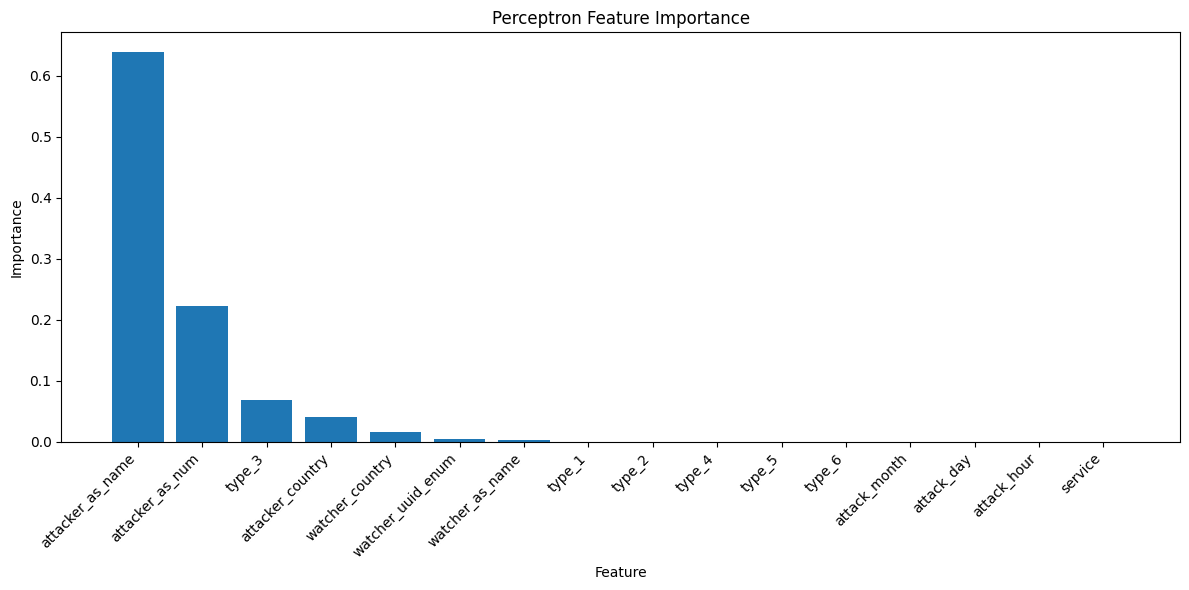

In [10]:
import matplotlib.pyplot as plt
train_df = pd.read_parquet('train_normalized.parq')
X_train = train_df.drop('label', axis=1)
coefficients = model.coef_[0]
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})
feature_importance_df['Importance'] = feature_importance_df['Importance'].abs()
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Perceptron Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()